# E5 - Prophet

Elaborado por GRUPO 1:
- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [25]:
#Paquetes necesarios
#!pip install pystan==2.19.1.1
#conda install -c conda-forge prophet

In [45]:
# Importar librerías

import pandas as pd
import numpy as np

%matplotlib inline

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from matplotlib import pyplot

In [28]:
# Leer data
df = pd.read_csv("DataSet/example_retail_sales.csv")

# Información del dataframe
df.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


In [29]:
df.describe ()

,y
count,293.000000
mean,308971.310580
std,86084.323897
min,146376.000000
25%,234503.000000
50%,314051.000000
75%,375795.000000
max,518253.000000


In [61]:
# Ajuste de Dataframe para que ds tenga formato fecha
df.dtypes
df['ds'] = pd.DatetimeIndex(df['ds'])
df.dtypes

ds       datetime64[ns]
y                 int64
log_y           float64
dtype: object

<AxesSubplot:>

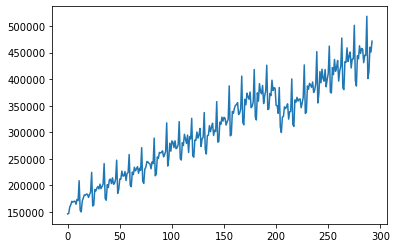

In [32]:
df['y'].plot()

COMENTARIO: En general, se tiene una serie creciente con comportamientos estacionales y un cambio de tendencia aaproximadamente a partir del dato 200 (es decir, del año 2009).

# Standardize the dataset using Numpy

In [62]:
df['log_y'] = np.log(df['y'])
df_log=df.iloc[:,[0,2]]
df_log.columns = ['time', 'log_y']
df_log.head()

,time,log_y
0,1992-01-01,11.893934
1,1992-02-01,11.898725
2,1992-03-01,11.978770
3,1992-04-01,12.005601
4,1992-05-01,12.043954


<AxesSubplot:>

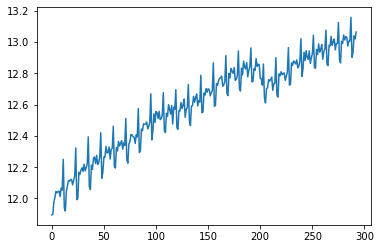

In [63]:
#df.log_y.plot()
df_log.log_y.plot()

COMENTARIO: Al estandarizar los datos aplicando logaritmo natural, se observa un comporatmiento similar al de la serie original.

La ventaja de transformar utilizando el logaritmo natural es que la diferencia de ellos es aproximadamente igual a la variación porcentual de la serie en los niveles originales.

# Train Model

In [36]:
m = Prophet()
m.fit(df_log)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Forcast 6 months future

In [51]:
future = m.make_future_dataframe(periods=6, freq='MS')
future.tail(6)

,ds
293,2016-06-01
294,2016-07-01
295,2016-08-01
296,2016-09-01
297,2016-10-01
298,2016-11-01


In [50]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
293,2016-06-01,13.055177,13.036676,13.073871
294,2016-07-01,13.056140,13.036252,13.076293
295,2016-08-01,13.076720,13.058037,13.096838
296,2016-09-01,13.009710,12.989880,13.030576
297,2016-10-01,13.048742,13.026334,13.070527
298,2016-11-01,13.053221,13.031034,13.074109


forecast is essentially a pandas dataframe and consists of a lot of fields. The predict method will assign each row in future a predicted value which it names yhat and the range is defined by yhat_lower andyhat_upper . These ranges can be considered as uncertainty levels.

### Plotting the Forecast

A continuación se muestran las proyecciones del modelo, tanto para los datos originales como para los 6 meses adicionales de pronóstico:

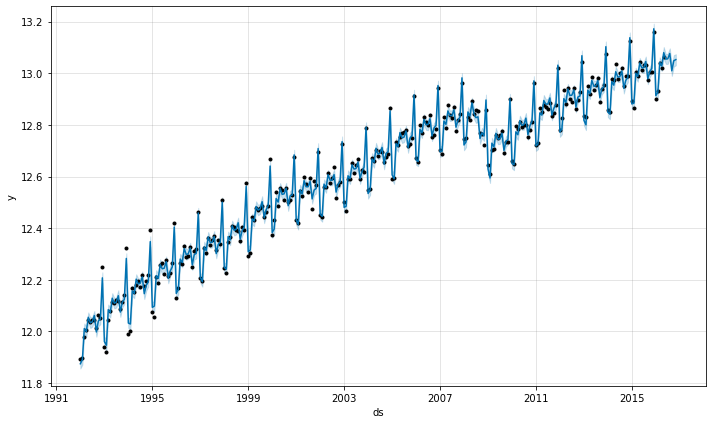

In [77]:
m.plot(forecast);

Haciendo zoom a los últimos doce meses, tenemos:

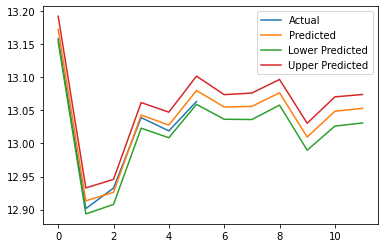

In [74]:
y_true = df_log['log_y'][-6:].values
y_pred = forecast['yhat'][-12:].values
y_pred_lower = forecast['yhat_lower'][-12:].values
y_pred_upper = forecast['yhat_upper'][-12:].values

pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.plot(y_pred_lower, label='Lower Predicted')
pyplot.plot(y_pred_upper, label='Upper Predicted')
pyplot.legend()
pyplot.show()

COMENTARIO: Los datos de los últimos 6 meses reales (línea azul) se encuentran dentro del intervalo de proyección del modelo (líneas roja y verde).

### Decomposing the Forecast 

En lo que sigue se detallan los componentes de tendencia y estacionalidad de la proyección del modelo:

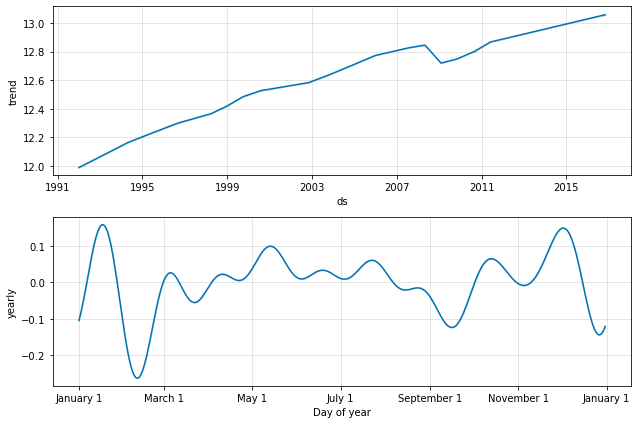

In [43]:
m.plot_components(forecast);

COMENTARIO 1: En lo que respecta a la tendencia, se observa una tendencia creciente con un ajuste de nivel en el año 2009. 

COMENTARIO 2: Frente a la estacionalidad, se observa que las ventas tienen mejor comportamiento en los meses de enero y de diciembre de cada año; así mismo, el mes de febrero es el de las peores ventas.

### Cross-validation

We can evaluate the performance of the predictions using the cross_validation function in Prophet.

In [40]:
from prophet.diagnostics import cross_validation

#data_cv = cross_validation(m, initial='24 months', period='6 month', horizon='12 month')
#data_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
data_cv = cross_validation(m, initial='730 days', period='180 days', horizon='180 days')

INFO:prophet:Making 45 forecasts with cutoffs between 1994-02-26 00:00:00 and 2015-11-03 00:00:00


INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.


In [41]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

performance_metrics(data_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days,0.001750,0.041831,0.030192,0.002394,0.001937,0.002398,0.435897
1,19 days,0.001655,0.040686,0.029077,0.002309,0.001916,0.002312,0.461538
2,20 days,0.001673,0.040897,0.029360,0.002327,0.001916,0.002330,0.461538
3,22 days,0.001646,0.040569,0.028594,0.002265,0.001763,0.002268,0.500000
4,23 days,0.001065,0.032634,0.023737,0.001872,0.001763,0.001871,0.538462
...,...,...,...,...,...,...,...,...
130,176 days,0.002987,0.054655,0.038703,0.003057,0.002287,0.003053,0.500000
131,177 days,0.002526,0.050257,0.035138,0.002757,0.002167,0.002752,0.448718
132,178 days,0.002544,0.050433,0.035417,0.002775,0.002167,0.002769,0.423077
133,179 days,0.002508,0.050082,0.034902,0.002732,0.002068,0.002727,0.461538


In [81]:
performance_metrics(data_cv).describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,135,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,102 days 21:41:20,0.002237,0.046550,0.034045,0.002691,0.001887,0.002691,0.520513
std,46 days 15:38:17.751321409,0.000762,0.008406,0.005983,0.000475,0.000351,0.000477,0.075030
min,18 days 00:00:00,0.000801,0.028296,0.022055,0.001734,0.000951,0.001732,0.346154
25%,64 days 12:00:00,0.001668,0.040836,0.030204,0.002385,0.001612,0.002382,0.466346
50%,106 days 00:00:00,0.002224,0.047164,0.034106,0.002702,0.001866,0.002696,0.512821
75%,142 days 12:00:00,0.002819,0.053092,0.039717,0.003136,0.002117,0.003142,0.554487
max,180 days 00:00:00,0.003833,0.061909,0.044561,0.003526,0.002690,0.003524,0.692308


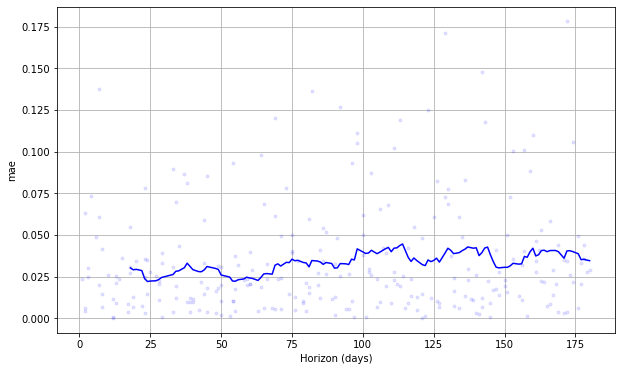

In [82]:
plot_cross_validation_metric(data_cv, metric='mae');

COMENTARIO: Luego de realizar el cross-validation y tomando como medida de desempeño el Error Absoluto Medio (MAE), se observa que la proyección de las ventas oscila entre 2.2% y 4.4%.